In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

In [17]:
torch.manual_seed(100)

In [8]:
n_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
class ReviewDataset(Dataset):
    def __init__(self, X, y, tokenizer):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        text = self.X.iloc[idx]
        y = self.y.iloc[idx]

        # Tokenize text input for model compatibility
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)

        return inputs['input_ids'].squeeze(), inputs['attention_mask'].squeeze(), torch.tensor(y, dtype=torch.long)

In [10]:
# Read in scale reviews dataset
data_path = 'drive/MyDrive/UMD/MSML641/Project/Data/CornellMovieReview_scale_data'

train_reviews = pd.read_csv(f'{data_path}/MovieReviewScaleData_Train_PolarityValence.csv')
val_reviews = pd.read_csv(f'{data_path}/MovieReviewScaleData_Val_PolarityValence.csv')
test_reviews = pd.read_csv(f'{data_path}/MovieReviewScaleData_Test_PolarityValence.csv')

train_reviews['Author'] = train_reviews['Author'].replace({'Steve+Rhodes':0,'James+Berardinelli':1,
                                                           'Scott+Renshaw':2,'Dennis+Schwartz':3})
val_reviews['Author'] = val_reviews['Author'].replace({'Steve+Rhodes':0,'James+Berardinelli':1,
                                                       'Scott+Renshaw':2,'Dennis+Schwartz':3})
test_reviews['Author'] = test_reviews['Author'].replace({'Steve+Rhodes':0,'James+Berardinelli':1,
                                                         'Scott+Renshaw':2,'Dennis+Schwartz':3})

batch_size = 128

# Initialize dataloaders. Need tokenizer. Use pretrained distilBERT tokenizer for corresponding model.
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
train_reviews = ReviewDataset(train_reviews['Review'],train_reviews['Author'], tokenizer)
train_dataloader = DataLoader(train_reviews, batch_size=batch_size, shuffle=True)

val_reviews = ReviewDataset(val_reviews['Review'],val_reviews['Author'], tokenizer)
val_dataloader = DataLoader(val_reviews, batch_size=batch_size, shuffle=False)

<ipython-input-10-f87fd68bfef7>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_reviews['Author'] = train_reviews['Author'].replace({'Steve+Rhodes':0,'James+Berardinelli':1,
<ipython-input-10-f87fd68bfef7>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_reviews['Author'] = val_reviews['Author'].replace({'Steve+Rhodes':0,'James+Berardinelli':1,
<ipython-input-10-f87fd68bfef7>:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitl

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [18]:
# Initialize model
model = RobertaForSequenceClassification.from_pretrained("roberta-base")
# Replace the final layer to have correct number of outputs
model.classifier.out_proj = nn.Linear(in_features = 768, out_features = 4, bias = True)
model.to(device)

for param in model.parameters():
    param.requires_grad = False

# Tune the last two transformer layers and classifier parameters
for param in model.roberta.encoder.layer[-2:].parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [20]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

n_epochs = 5

# Train the model
model.train()
for epoch in tqdm(range(n_epochs)):
    correct_train = 0
    correct_val = 0
    total_train_samples = 0
    total_val_samples = 0
    epoch_loss_train = 0
    epoch_loss_val = 0

    #if epoch == 5: # Stop tuning transformer here, continue with just classifier head
    #    for param in model.roberta.encoder.layer[-2:].parameters():
    #        param.requires_grad = False

    # Train the model
    for input_ids, attention_mask, labels in train_dataloader:

        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        pred = model(input_ids, attention_mask).logits

        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        epoch_loss_train += loss.item()

        # Calculate accuracy for current batch
        pred = pred.argmax(dim=1)

        correct_train += (pred == labels).sum().item()
        total_train_samples += labels.size(0)

        del input_ids, attention_mask, labels, pred, loss

    train_loss.append(epoch_loss_train)
    train_accuracy = (correct_train / total_train_samples) * 100
    train_acc.append(train_accuracy)

    # Validate
    with torch.no_grad():
        model.eval()

        for input_ids, attention_mask, labels in val_dataloader:

            input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
            labels = labels.to(device)

            pred = model(input_ids, attention_mask).logits

            loss = criterion(pred, labels)
            epoch_loss_val += loss.item()

            # Calculate accuracy for current batch
            pred = pred.argmax(dim=1)

            correct_val += (pred == labels).sum().item()
            total_val_samples += labels.size(0)

            del input_ids, attention_mask, labels, pred, loss

    val_loss.append(epoch_loss_val)
    val_accuracy = (correct_val / total_val_samples) * 100
    val_acc.append(val_accuracy)

    print(f"Epoch {epoch+1}, Train Accuracy: {round(train_accuracy,5)}, Validation Accuracy: {round(val_accuracy,5)}")

 20%|██        | 1/5 [00:46<03:05, 46.28s/it]

Epoch 1, Train Accuracy: 39.58333, Validation Accuracy: 58.04196


 40%|████      | 2/5 [01:31<02:17, 45.72s/it]

Epoch 2, Train Accuracy: 75.97032, Validation Accuracy: 88.11189


 60%|██████    | 3/5 [02:16<01:30, 45.50s/it]

Epoch 3, Train Accuracy: 91.01027, Validation Accuracy: 92.40759


 80%|████████  | 4/5 [03:01<00:45, 45.35s/it]

Epoch 4, Train Accuracy: 92.97945, Validation Accuracy: 89.41059


100%|██████████| 5/5 [03:47<00:00, 45.42s/it]

Epoch 5, Train Accuracy: 95.51941, Validation Accuracy: 94.80519


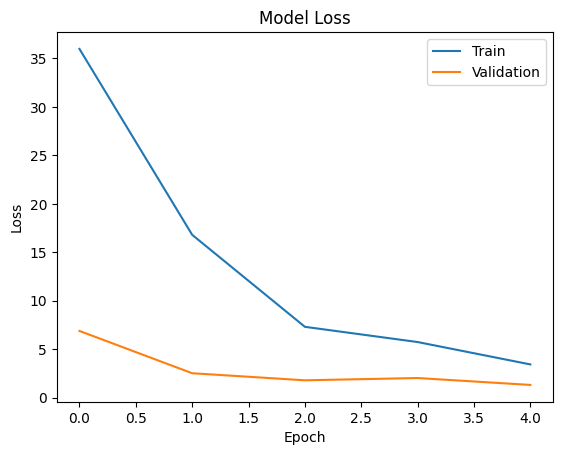

In [21]:
plt.title('Model Loss')
plt.plot([i for i in range(n_epochs)], train_loss, label='Train')
plt.plot([i for i in range(n_epochs)], val_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.close()

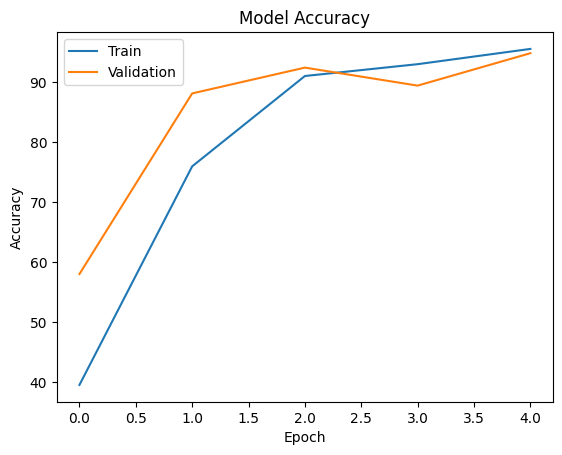

In [22]:
plt.title('Model Accuracy')
plt.plot([i for i in range(n_epochs)], train_acc, label='Train')
plt.plot([i for i in range(n_epochs)], val_acc, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.close()

In [23]:
import numpy as np
# Validate
with torch.no_grad():
    model.eval()

    i=0
    for input_ids, attention_mask, labels in val_dataloader:

        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        labels = labels.to(device)

        pred = model(input_ids, attention_mask).logits

        loss = criterion(pred, labels)
        val_loss.append(loss.item())

        # Calculate accuracy for current batch
        pred = pred.argmax(dim=1)

        correct_val += (pred == labels).sum().item()
        total_val_samples += labels.size(0)

        if i == 0:
            all_pred = pred.cpu().detach().numpy()
            all_labels = labels.cpu().detach().numpy()
            i+=1
        else:
            all_pred = np.concatenate([all_pred,pred.cpu().detach().numpy()])
            all_labels = np.concatenate([all_labels,labels.cpu().detach().numpy()])

        del input_ids, attention_mask, labels, pred, loss

val_accuracy = (correct_val / total_val_samples) * 100
print(f"Final validation accuracy:", val_accuracy)

Final validation accuracy: 94.8051948051948


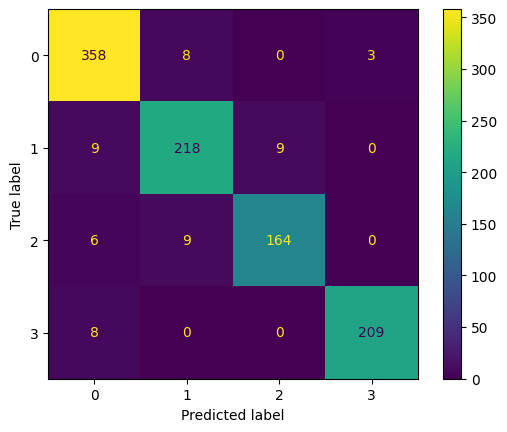

In [24]:
cm = confusion_matrix(all_labels, all_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [25]:
f1_score(all_labels, all_pred, average='weighted')

0.9480181788131545

# Get test results

In [26]:
test_reviews = ReviewDataset(test_reviews['Review'],test_reviews['Author'], tokenizer)
test_dataloader = DataLoader(test_reviews, batch_size=batch_size, shuffle=False)

In [27]:
import numpy as np
# Validate
with torch.no_grad():
    model.eval()

    test_loss = []
    correct_test = 0
    total_test_samples = 0
    i=0
    for input_ids, attention_mask, labels in test_dataloader:

        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        labels = labels.to(device)

        pred = model(input_ids, attention_mask).logits

        loss = criterion(pred, labels)
        test_loss.append(loss.item())

        # Calculate accuracy for current batch
        pred = pred.argmax(dim=1)

        correct_test += (pred == labels).sum().item()
        total_test_samples += labels.size(0)

        if i == 0:
            all_pred = pred.cpu().detach().numpy()
            all_labels = labels.cpu().detach().numpy()
            i+=1
        else:
            all_pred = np.concatenate([all_pred,pred.cpu().detach().numpy()])
            all_labels = np.concatenate([all_labels,labels.cpu().detach().numpy()])

        del input_ids, attention_mask, labels, pred, loss

test_accuracy = (correct_test / total_test_samples) * 100
print(f"Test Accuracy:", test_accuracy)

Test Accuracy: 92.81437125748504


Test confusion matrix

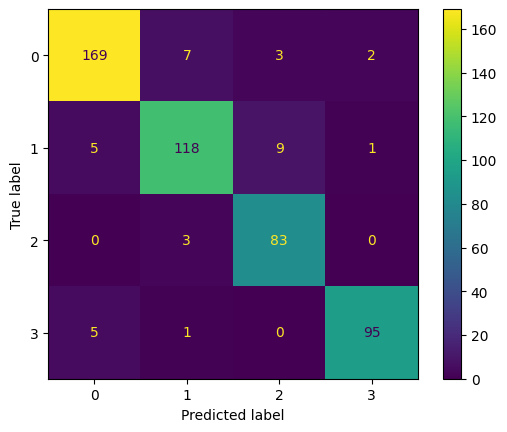

In [28]:
cm = confusion_matrix(all_labels, all_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Testing F1 score

In [29]:
f1_score(all_labels, all_pred,average='weighted')

0.928234540094335